Libraries

In [1]:
import pandas as pd       
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import cv2

import warnings
warnings.filterwarnings('ignore')

import random
import os
import glob
from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from tensorflow.random import set_seed
set_seed(42)

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

Reading Datasets

In [3]:
main_path = "chest_xray/"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

In [4]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]



test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]


val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns = ['class'])
df_val['image'] = [x for x in val_list]

In [5]:
df_train
df_test
df_val

,class,image
0,Normal,chest_xray/val/NORMAL\NORMAL2-IM-1427-0001.jpeg
1,Normal,chest_xray/val/NORMAL\NORMAL2-IM-1430-0001.jpeg
2,Normal,chest_xray/val/NORMAL\NORMAL2-IM-1431-0001.jpeg
3,Normal,chest_xray/val/NORMAL\NORMAL2-IM-1436-0001.jpeg
4,Normal,chest_xray/val/NORMAL\NORMAL2-IM-1437-0001.jpeg
5,Normal,chest_xray/val/NORMAL\NORMAL2-IM-1438-0001.jpeg
6,Normal,chest_xray/val/NORMAL\NORMAL2-IM-1440-0001.jpeg
7,Normal,chest_xray/val/NORMAL\NORMAL2-IM-1442-0001.jpeg
8,Pneumonia,chest_xray/val/PNEUMONIA\person1946_bacteria_4...
9,Pneumonia,chest_xray/val/PNEUMONIA\person1946_bacteria_4...


EDA

In [6]:
Pneumonia = df_train[(df_train['class'] == 'Pneumonia')]
Normal = df_train[(df_train['class'] == 'Normal')]

trace = go.Bar(x = (len(Pneumonia), len(Normal)), y = ['Pneumonia', 'Normal'], orientation = 'h', opacity = 0.8, marker=dict(
        color=['gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of class variable in train dataset')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [7]:
trace = go.Pie(labels = ['Pneumonia', 'Normal'], values = df_train['class'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of class variable in train dataset')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

EDA

In [8]:
Pneumonia = df_train[(df_train['class'] == 'Pneumonia')]
Normal = df_train[(df_train['class'] == 'Normal')]

trace = go.Bar(x = (len(Pneumonia), len(Normal)), y = ['Pneumonia', 'Normal'], orientation = 'h', opacity = 0.8, marker=dict(
        color=['gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of class variable in train dataset')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [9]:
trace = go.Pie(labels = ['Pneumonia', 'Normal'], values = df_train['class'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of class variable in train dataset')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [10]:
trace = go.Pie(labels = ['Pneumonia', 'Normal'], values = df_test['class'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of class variable in test dataset')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

Previewing the images

Train Set - Normal


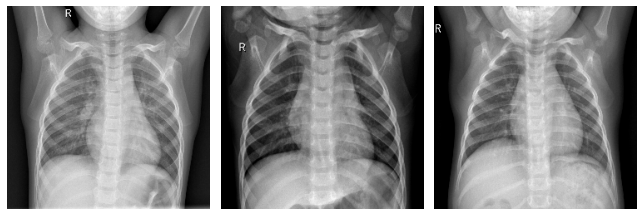

Train Set - Pneumonia


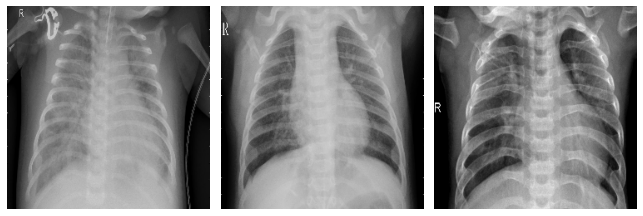

In [11]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 3):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (244,244))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()


print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 3):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (244,244))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Data Splitting

In [12]:
train_df, val_df = train_test_split(df_train, test_size = 0.2, random_state = SEED, stratify = df_train['class'])

Data Augmentation [Increase Data]

In [13]:

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Setting callbakcs

In [14]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

Create Model

In [15]:
def get_model():
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [16]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [17]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 213s 2s/step - loss: 0.4678 - binary_accuracy: 0.7895 - val_loss: 1.1654 - val_binary_accuracy: 0.7433 - lr: 3.0000e-05
Epoch 2/50
130/130 [==============================] - 197s 2s/step - loss: 0.2987 - binary_accuracy: 0.8744 - val_loss: 1.9815 - val_binary_accuracy: 0.7433 - lr: 3.0000e-05
Epoch 3/50
131/130 [==============================] - ETA: 0s - loss: 0.2600 - binary_accuracy: 0.8885
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
130/130 [==============================] - 194s 1s/step - loss: 0.2600 - binary_accuracy: 0.8885 - val_loss: 2.0424 - val_binary_accuracy: 0.7433 - lr: 3.0000e-05
Epoch 4/50
130/130 [==============================] - 185s 1s/step - loss: 0.2322 - binary_accuracy: 0.9063 - val_loss: 1.2114 - val_binary_accuracy: 0.7433 - lr: 6.0000e-06
Epoch 5/50
130/130 [==============================] - 179s 1s/step - loss: 0.2157 - binary_accuracy: 0.9111 - val_loss: 0.2337 - val_bi

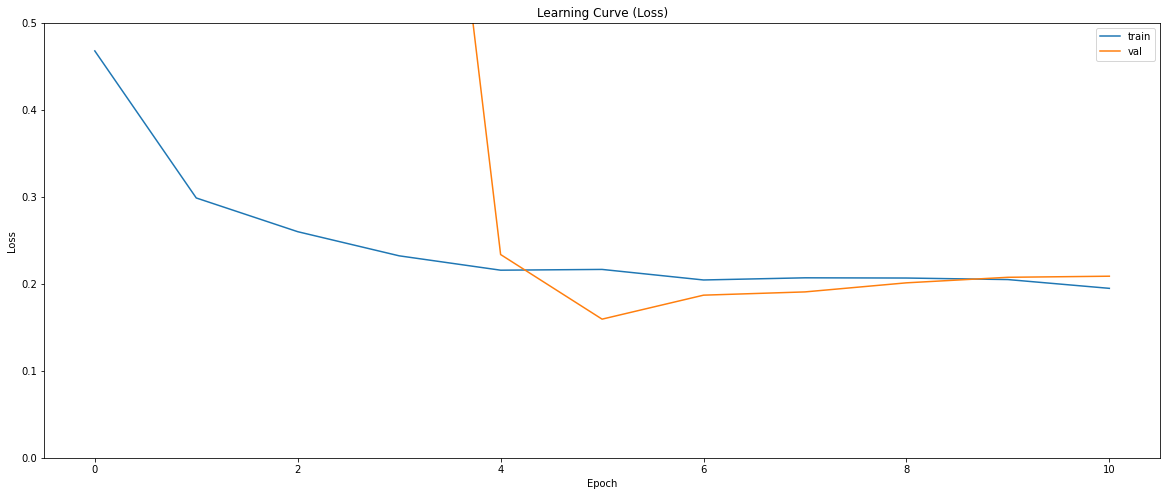

In [18]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

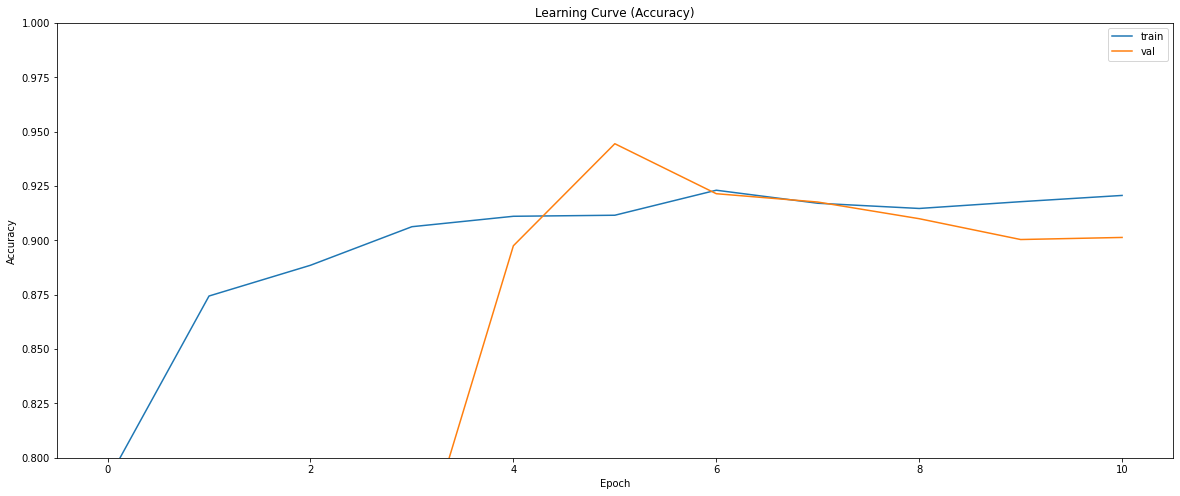

In [19]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [20]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1594177782535553
Val accuracy: 0.9444444179534912


In [21]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4482426345348358
Test accuracy: 0.8269230723381042


In [22]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [23]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [24]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 607s 5s/step - loss: 0.3573 - binary_accuracy: 0.8387 - val_loss: 0.1985 - val_binary_accuracy: 0.9224 - lr: 5.0000e-05
Epoch 2/50
130/130 [==============================] - 566s 4s/step - loss: 0.2020 - binary_accuracy: 0.9288 - val_loss: 0.1686 - val_binary_accuracy: 0.9272 - lr: 5.0000e-05
Epoch 3/50
130/130 [==============================] - 588s 5s/step - loss: 0.1708 - binary_accuracy: 0.9331 - val_loss: 0.1394 - val_binary_accuracy: 0.9454 - lr: 5.0000e-05
Epoch 4/50
130/130 [==============================] - 582s 4s/step - loss: 0.1488 - binary_accuracy: 0.9463 - val_loss: 0.1327 - val_binary_accuracy: 0.9492 - lr: 5.0000e-05
Epoch 5/50
130/130 [==============================] - 549s 4s/step - loss: 0.1414 - binary_accuracy: 0.9470 - val_loss: 0.1182 - val_binary_accuracy: 0.9540 - lr: 5.0000e-05
Epoch 6/50
130/130 [==============================] - 567s 4s/step - loss: 0.1275 - binary_accuracy: 0.9521 - val_loss: 0.1048 - v

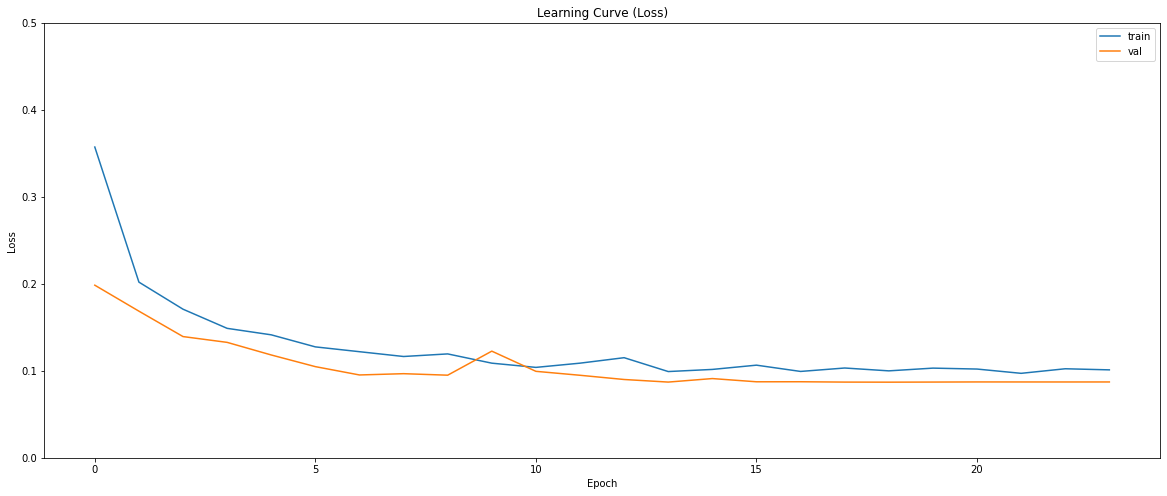

In [25]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

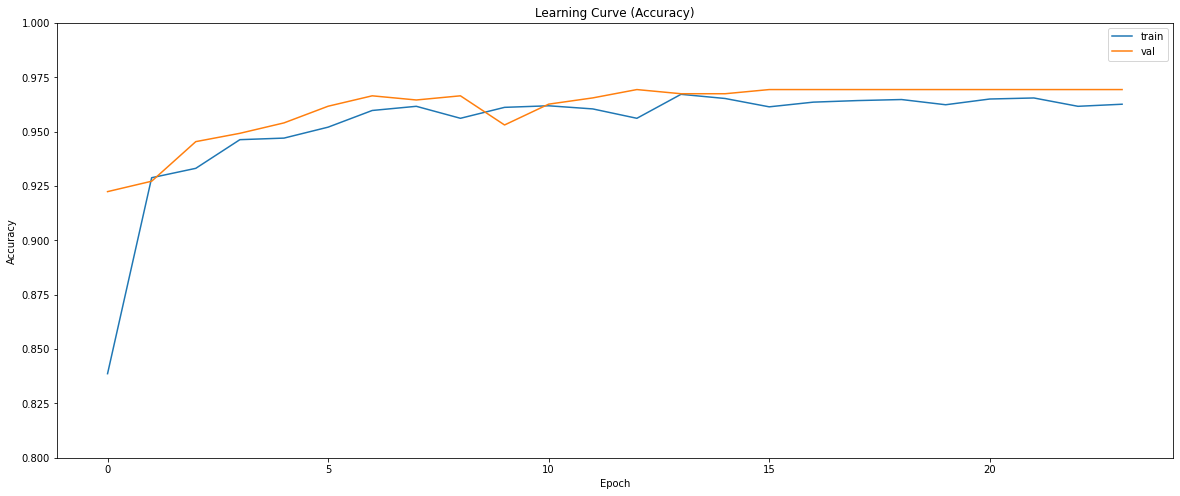

In [26]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [27]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.08695531636476517
Val accuracy: 0.969348669052124


In [28]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.44861528277397156
Test accuracy: 0.8381410241127014


Fine Tuning

In [29]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [30]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [31]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 505s 4s/step - loss: 0.1037 - binary_accuracy: 0.9631 - val_loss: 0.0870 - val_binary_accuracy: 0.9693 - lr: 1.6000e-08
Epoch 2/50
130/130 [==============================] - 504s 4s/step - loss: 0.0973 - binary_accuracy: 0.9650 - val_loss: 0.0870 - val_binary_accuracy: 0.9693 - lr: 1.6000e-08
Epoch 3/50
131/130 [==============================] - ETA: -1s - loss: 0.1039 - binary_accuracy: 0.9616
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.1999999094978194e-09.
130/130 [==============================] - 504s 4s/step - loss: 0.1039 - binary_accuracy: 0.9616 - val_loss: 0.0870 - val_binary_accuracy: 0.9693 - lr: 1.6000e-08
Epoch 4/50
130/130 [==============================] - 503s 4s/step - loss: 0.1080 - binary_accuracy: 0.9585 - val_loss: 0.0870 - val_binary_accuracy: 0.9693 - lr: 3.2000e-09
Epoch 5/50
131/130 [==============================] - ETA: -1s - loss: 0.1022 - binary_accuracy: 0.9633
Epoch 5: ReduceLROnPlateau red

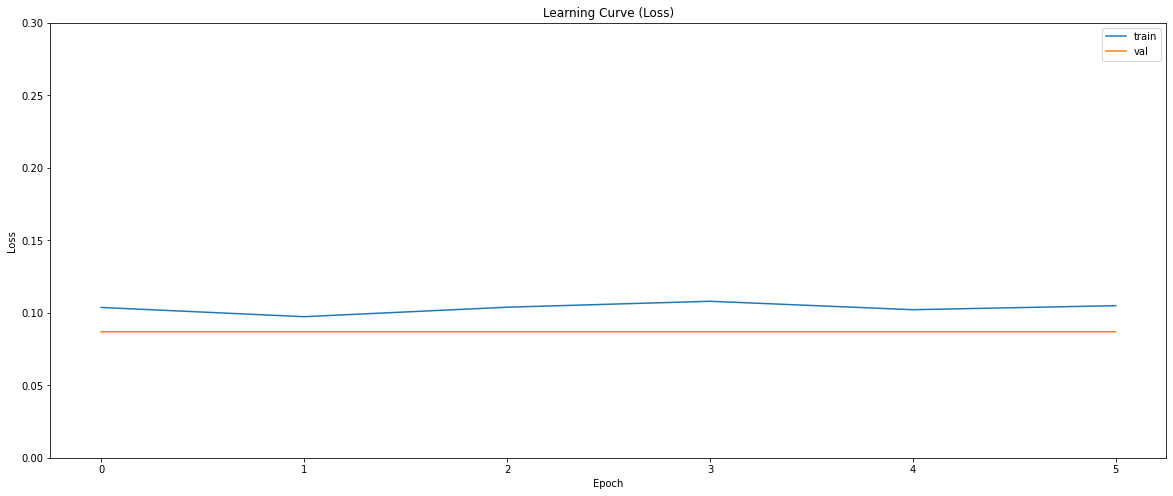

In [32]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.3)
ax.legend(['train', 'val'], loc='best')
plt.show()

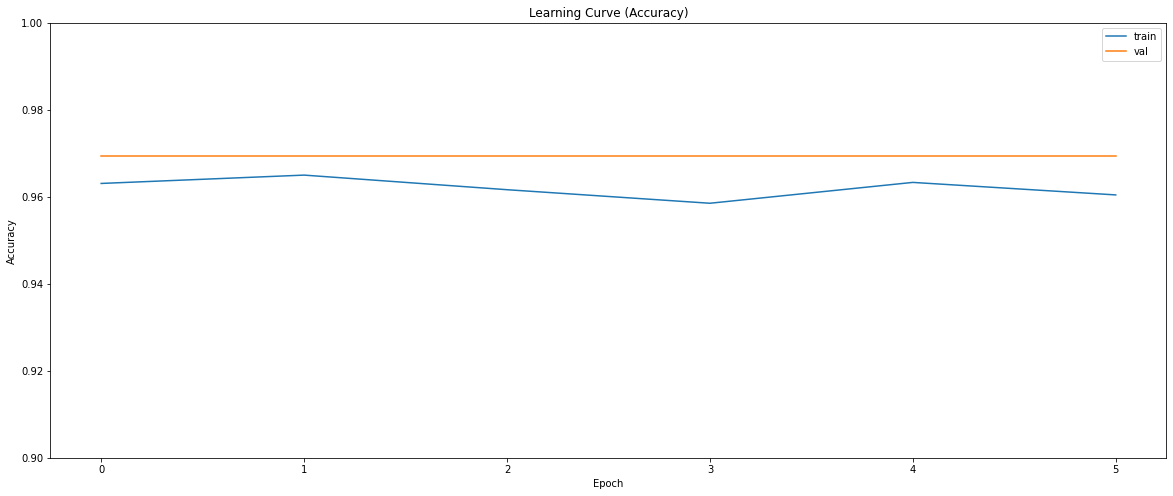

In [33]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.90, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [34]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.0869632288813591
Val accuracy: 0.969348669052124


In [35]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.44856423139572144
Test accuracy: 0.8381410241127014


Evaluation

In [36]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [37]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [38]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.8381410256410257


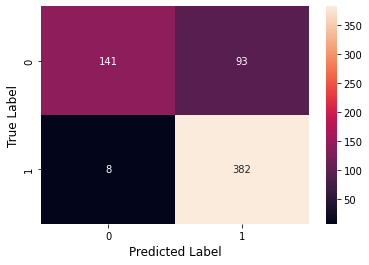

In [39]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [40]:
print(classification_report(Y_test, pred_labels, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.95      0.60      0.74       234
   Normal (Class 1)       0.80      0.98      0.88       390

           accuracy                           0.84       624
          macro avg       0.88      0.79      0.81       624
       weighted avg       0.86      0.84      0.83       624

